In [1]:
import pandas as pd

In [2]:
# Load the lag analysis data
lag_analysis_cal = pd.read_csv('../data/features/q_buffer2_pair_lag.csv')
lag_analysis_cal.head()
# Run the watershed correlation analysis with inset maps
# run_watershed_correlation_analysis()

,well_id,date,wte,gse,gage_id,well_lat,well_lon,gage_lat,gage_lon,wte_meters,q,bfd,delta_wte,delta_q,year,date_prev,delta_wte_lag1_year
0,411605111481601,1933-08-08,4830.264808,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.264713,16.0,1.0,-3.545192,-22.0,1933,1932-08-08,0.000000
1,411605111481601,1933-08-09,4830.250000,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.260200,15.0,1.0,-3.560000,-23.0,1933,1932-08-09,-0.002727
2,411605111481601,1933-08-10,4830.230000,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.254104,14.0,1.0,-3.580000,-24.0,1933,1932-08-10,-0.005370
3,411605111481601,1933-08-11,4830.205238,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.246557,12.0,1.0,-3.604762,-26.0,1933,1932-08-11,-0.007930
4,411605111481601,1933-08-12,4830.178571,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.238429,12.0,1.0,-3.631429,-26.0,1933,1932-08-12,-0.010409


In [6]:
no_lag = pd.read_csv('../data/features/q_buffer2_pair_delta_30m.csv')
no_lag.head()

,well_id,date,wte,gse,gage_id,well_lat,well_lon,gage_lat,gage_lon,wte_meters,q,bfd,delta_wte,delta_q
0,3.946430e+14,1975-01-01,5954.322586,5955.0,10152000,39.778571,-111.487970,40.150232,-111.726039,1814.877524,96.0,1.0,0.000000,0.0
1,4.005100e+14,1975-01-01,4642.123472,4720.0,10152000,40.086067,-111.595474,40.150232,-111.726039,1414.919234,96.0,1.0,0.000000,0.0
2,4.005270e+14,1975-01-01,4595.247928,4622.0,10152000,40.090788,-111.657423,40.150232,-111.726039,1400.631568,96.0,1.0,0.000000,0.0
3,4.005270e+14,1975-01-01,4603.818829,4640.0,10152000,40.090788,-111.660479,40.150232,-111.726039,1403.243979,96.0,1.0,8.570901,0.0
4,4.005280e+14,1975-01-01,4599.508513,4625.0,10152000,40.091066,-111.657423,40.150232,-111.726039,1401.930195,96.0,1.0,0.000000,0.0


# no lag

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Function to calculate mutual information
def calculate_mutual_info(x, y, n_bins=10):
    """
    Compute mutual information between two continuous variables using discretization.
    Both x and y are expected to be 1D arrays.
    """
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]

    if len(x_clean) < 10:  # Require a minimum of 10 samples
        return np.nan

    # Discretize continuous variables
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    x_discrete = discretizer.fit_transform(x_clean.reshape(-1, 1)).flatten()
    y_discrete = discretizer.fit_transform(y_clean.reshape(-1, 1)).flatten()

    # Calculate mutual information
    mi = mutual_info_score(x_discrete, y_discrete)
    return mi

# Function to calculate metrics per well
def calculate_well_metrics(well_data):
    """
    Calculate MI, Pearson r, and Spearman r for a single well's data.
    """
    # Extract variables
    delta_wte = well_data['delta_wte'].values
    delta_q = well_data['delta_q'].values

    # Mutual Information
    mi = calculate_mutual_info(delta_wte, delta_q, n_bins=10)

    # Pearson Correlation
    if len(delta_wte) > 1 and np.std(delta_wte) > 0 and np.std(delta_q) > 0:
        pearson_corr, _ = pearsonr(delta_wte, delta_q)
    else:
        pearson_corr = np.nan

    # Spearman Correlation
    if len(delta_wte) > 1:
        spearman_corr, _ = spearmanr(delta_wte, delta_q)
    else:
        spearman_corr = np.nan

    return pd.Series({
        'mi_delta_wte_delta_q': mi,
        'pearson_r': pearson_corr,
        'spearman_r': spearman_corr,
        'n_records': len(well_data)  # Total number of valid data points
    })

# Filter dataset to ensure no NaNs in columns of interest
filtered_no_lag = no_lag.dropna(subset=['delta_wte', 'delta_q'])

# Compute metrics grouped by well and gage
results = (
    filtered_no_lag
    .groupby(['well_id', 'gage_id'])
    .apply(calculate_well_metrics)  # Apply metrics calculation
    .reset_index()  # Reset index for cleaner output
)

# Save and display results
results.to_csv('../data/features/well_gage_mi_analysis_no_lag.csv', index=False)
print(results.head())

        well_id   gage_id  mi_delta_wte_delta_q  pearson_r  spearman_r  \
0  3.946430e+14  10152000              0.157596   0.253425    0.230367   
1  3.948130e+14  10152000              0.273676   0.394657    0.443180   
2  4.002190e+14  10141000              0.055215   0.066995    0.060992   
3  4.005100e+14  10152000              0.260221   0.274720    0.297157   
4  4.005270e+14  10152000              0.129083   0.185049    0.131291   

   n_records  
0     2679.0  
1     2679.0  
2     7560.0  
3     2679.0  
4     3697.0  


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_74951/1801215020.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_well_metrics)  # Apply metrics calculation


# lag

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Load lag_analysis_cal dataset (replace path if necessary)
lag_analysis_cal = pd.read_csv('../data/features/q_buffer2_pair_lag.csv')

# Function to calculate mutual information
def calculate_mutual_info(x, y, n_bins=10):
    """
    Compute mutual information between two continuous variables using discretization.
    Both x and y are expected to be 1D arrays.
    """
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]

    if len(x_clean) < 10:  # Require a minimum of 10 samples
        return np.nan

    # Discretize continuous variables
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    x_discrete = discretizer.fit_transform(x_clean.reshape(-1, 1)).flatten()
    y_discrete = discretizer.fit_transform(y_clean.reshape(-1, 1)).flatten()

    # Calculate mutual information
    mi = mutual_info_score(x_discrete, y_discrete)
    return mi

# Function to calculate metrics per gage
def calculate_gage_metrics(gage_data):
    """
    Calculate MI, Pearson r, and Spearman r for a single gage's data.
    """
    # Extract variables
    delta_q = gage_data['delta_q'].values
    delta_wte_lag1_year = gage_data['delta_wte_lag1_year'].values

    # Mutual Information
    mi = calculate_mutual_info(delta_wte_lag1_year, delta_q, n_bins=10)

    # Pearson Correlation
    if len(delta_q) > 1 and np.std(delta_q) > 0 and np.std(delta_wte_lag1_year) > 0:
        pearson_corr, _ = pearsonr(delta_wte_lag1_year, delta_q)
    else:
        pearson_corr = np.nan

    # Spearman Correlation
    if len(delta_wte_lag1_year) > 1:
        spearman_corr, _ = spearmanr(delta_wte_lag1_year, delta_q)
    else:
        spearman_corr = np.nan

    return pd.Series({
        'mi_delta_wte_delta_q': mi,
        'pearson_r': pearson_corr,
        'spearman_r': spearman_corr,
        'n_records': len(gage_data)  # Total number of valid data points
    })

# Filter dataset to ensure no NaNs in columns of interest
filtered_lag_analysis_cal = lag_analysis_cal.dropna(subset=['delta_q', 'delta_wte_lag1_year'])

# Compute metrics grouped by gage and well
results = (
    filtered_lag_analysis_cal
    .groupby(['gage_id', 'well_id'])
    .apply(calculate_gage_metrics)  # Apply metrics calculation
    .reset_index()  # Reset index for cleaner output
)

# Save and display results
results.to_csv('../data/features/well_gage_mi_lag.csv', index=False)
print(results.head())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:334: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1316217789.py:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(delta_wte_lag1_year, delta_q)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:334: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1316217789.py:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(delta_wte_lag1_year, delta_q)


    gage_id          well_id  mi_delta_wte_delta_q  pearson_r  spearman_r  \
0  10126000  410202110560201              0.226203   0.142116    0.192721   
1  10126000  411643110583401              0.151724  -0.149978   -0.038776   
2  10126000  412058111002901              0.355848  -0.409583   -0.489287   
3  10126000  412248111020301              0.111064   0.017410    0.031522   
4  10126000  413124111071601              0.086769  -0.072004   -0.077888   

   n_records  
0      682.0  
1      954.0  
2      380.0  
3      902.0  
4     1233.0  


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1316217789.py:71: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_gage_metrics)  # Apply metrics calculation


In [6]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gage_id               879 non-null    int64  
 1   well_id               879 non-null    int64  
 2   mi_delta_wte_delta_q  863 non-null    float64
 3   pearson_r             871 non-null    float64
 4   spearman_r            871 non-null    float64
 5   n_records             879 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 41.3 KB


# comparison

In [8]:
lag_mi = pd.read_csv('../data/features/well_gage_mi_lag.csv')
lag_mi.head()

,gage_id,well_id,mi_delta_wte_delta_q,pearson_r,spearman_r,n_records
0,10126000,410202110560201,0.226203,0.142116,0.192721,682.0
1,10126000,411643110583401,0.151724,-0.149978,-0.038776,954.0
2,10126000,412058111002901,0.355848,-0.409583,-0.489287,380.0
3,10126000,412248111020301,0.111064,0.017410,0.031522,902.0
4,10126000,413124111071601,0.086769,-0.072004,-0.077888,1233.0


In [11]:
lag_mi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gage_id               879 non-null    int64  
 1   well_id               879 non-null    int64  
 2   mi_delta_wte_delta_q  863 non-null    float64
 3   pearson_r             871 non-null    float64
 4   spearman_r            871 non-null    float64
 5   n_records             879 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 41.3 KB


In [9]:
no_lag_mi = pd.read_csv('../data/features/well_gage_mi_no_lag.csv')
no_lag_mi.head()

,well_id,gage_id,mi_delta_wte_delta_q,pearson_r,spearman_r,n_records
0,394618111291501,10152000,0.095602,0.156951,0.215294,3799.0
1,394643111291401,10152000,0.102255,0.157206,0.103073,3448.0
2,394813111291901,10152000,0.061242,0.204473,0.159445,9140.0
3,400219111393701,10141000,0.067289,0.160288,0.193785,11926.0
4,400440111365401,10152000,0.106116,-0.218405,-0.208220,5227.0


In [10]:
no_lag_mi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   well_id               1096 non-null   int64  
 1   gage_id               1096 non-null   int64  
 2   mi_delta_wte_delta_q  1088 non-null   float64
 3   pearson_r             1089 non-null   float64
 4   spearman_r            1089 non-null   float64
 5   n_records             1096 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 51.5 KB


=== Overall Summary ===
pairs: 879
mi_lag_mean: 0.2775
mi_no_lag_mean: 0.2035
mi_lag_median: 0.1806
mi_no_lag_median: 0.1460
delta_mi_mean: 0.0810
delta_mi_median: 0.0347
pct_pairs_lag_higher: 76.2230
pct_pairs_lag_much_higher_(>0.02): 62.7986
nl_gain_lag_mean: 0.0955
nl_gain_no_lag_mean: 0.0145
delta_nl_gain_mean: 0.0838

=== By-Gage (Top 10 by delta_mi_mean) ===
    gage_id  wells  mi_lag_mean  mi_no_lag_mean  delta_mi_mean  \
5  10168000     38     0.389938        0.190316       0.199622   
1  10141000    307     0.370808        0.250546       0.121688   
4  10163000    136     0.309230        0.281213       0.051001   
0  10126000    368     0.185352        0.141354       0.050450   
3  10152000     25     0.156979        0.139506       0.017473   
2  10143500      5     0.161156        0.188045      -0.026889   

   pct_wells_lag_higher  pct_wells_lag_much_higher  nl_gain_lag_mean  \
5             71.052632                  47.368421          0.079453   
1             80.130293   

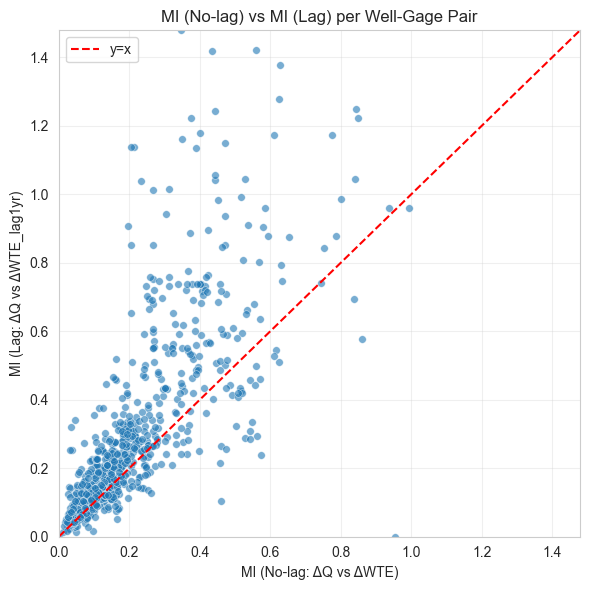

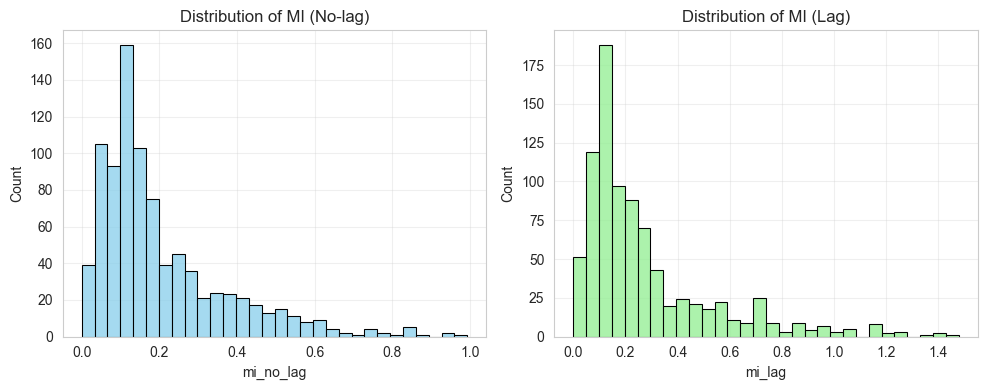

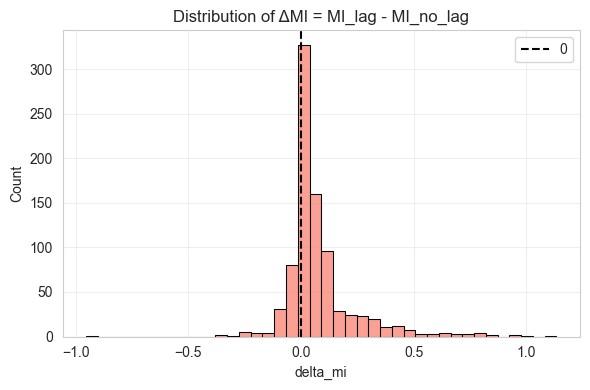

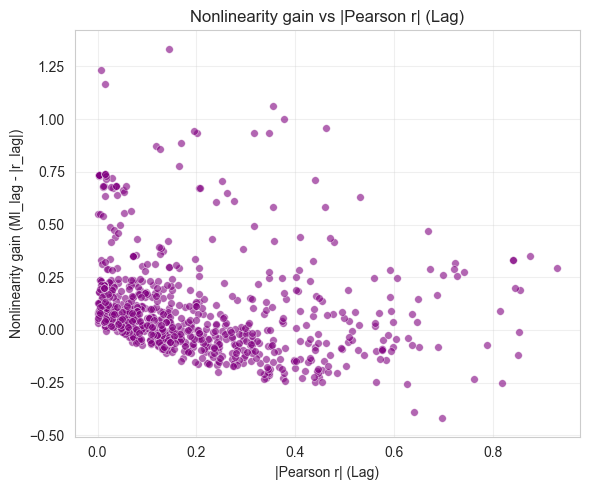

In [12]:
# Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1) 读取两类 MI 结果
lag_mi = pd.read_csv('../data/features/well_gage_mi_lag.csv')       # 来自滞后版 ΔQ vs ΔWTE_lag1_year
no_lag_mi = pd.read_csv('../data/features/well_gage_mi_no_lag.csv') # 来自同期 ΔQ vs ΔWTE

# 2) 标准化列名（确保 join 键一致）
# lag_mi: gage_id, well_id, mi_delta_wte_delta_q, pearson_r, spearman_r, n_records
# no_lag_mi: well_id, gage_id, mi_delta_wte_delta_q, pearson_r, spearman_r, n_records
lag_mi = lag_mi.rename(columns={
    'mi_delta_wte_delta_q': 'mi_lag',
    'pearson_r': 'pearson_lag',
    'spearman_r': 'spearman_lag',
    'n_records': 'n_records_lag'
})
no_lag_mi = no_lag_mi.rename(columns={
    'mi_delta_wte_delta_q': 'mi_no_lag',
    'pearson_r': 'pearson_no_lag',
    'spearman_r': 'spearman_no_lag',
    'n_records': 'n_records_no_lag'
})

# 3) 合并（井-站点对）
merged = pd.merge(
    no_lag_mi,
    lag_mi,
    on=['well_id', 'gage_id'],
    how='inner',
    validate='one_to_one'
)

# 4) 计算对比指标
eps = 1e-9
merged['delta_mi'] = merged['mi_lag'] - merged['mi_no_lag']
merged['ratio_mi'] = merged['mi_lag'] / (merged['mi_no_lag'] + eps)

# 非线性指示（相对线性皮尔逊的“提升”）
# 定义一种简易非线性指标：nl_gain = mi_lag - |pearson_lag|
merged['nl_gain_lag'] = merged['mi_lag'] - merged['pearson_lag'].abs()
merged['nl_gain_no_lag'] = merged['mi_no_lag'] - merged['pearson_no_lag'].abs()
merged['delta_nl_gain'] = merged['nl_gain_lag'] - merged['nl_gain_no_lag']

# 5) 全局汇总
summary = {
    'pairs': len(merged),
    'mi_lag_mean': merged['mi_lag'].mean(),
    'mi_no_lag_mean': merged['mi_no_lag'].mean(),
    'mi_lag_median': merged['mi_lag'].median(),
    'mi_no_lag_median': merged['mi_no_lag'].median(),
    'delta_mi_mean': merged['delta_mi'].mean(),
    'delta_mi_median': merged['delta_mi'].median(),
    'pct_pairs_lag_higher': (merged['delta_mi'] > 0).mean() * 100,
    'pct_pairs_lag_much_higher_(>0.02)': (merged['delta_mi'] > 0.02).mean() * 100,
    'nl_gain_lag_mean': merged['nl_gain_lag'].mean(),
    'nl_gain_no_lag_mean': merged['nl_gain_no_lag'].mean(),
    'delta_nl_gain_mean': merged['delta_nl_gain'].mean()
}
print("=== Overall Summary ===")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# 6) 按 gage 聚合：统计“滞后更好”的比例
by_gage = merged.groupby('gage_id').agg(
    wells=('well_id', 'count'),
    mi_lag_mean=('mi_lag', 'mean'),
    mi_no_lag_mean=('mi_no_lag', 'mean'),
    delta_mi_mean=('delta_mi', 'mean'),
    pct_wells_lag_higher=('delta_mi', lambda x: (x > 0).mean() * 100),
    pct_wells_lag_much_higher=('delta_mi', lambda x: (x > 0.02).mean() * 100),
    nl_gain_lag_mean=('nl_gain_lag','mean'),
    nl_gain_no_lag_mean=('nl_gain_no_lag','mean'),
    delta_nl_gain_mean=('delta_nl_gain','mean')
).reset_index().sort_values('delta_mi_mean', ascending=False)

print("\n=== By-Gage (Top 10 by delta_mi_mean) ===")
print(by_gage.head(10))

# 7) 找出“滞后显著优于同期”的井（可调整阈值）
significant_improved = merged[
    (merged['delta_mi'] > 0.02) &
    (merged['mi_lag'] > 0.08)
].copy().sort_values('delta_mi', ascending=False)

print(f"\nWells with significant improvement (delta_mi > 0.02 & mi_lag > 0.08): {len(significant_improved)}")
print(significant_improved[['well_id','gage_id','mi_no_lag','mi_lag','delta_mi','nl_gain_no_lag','nl_gain_lag','delta_nl_gain']].head(10))

# 8) 可视化
os.makedirs('../reports/figures/mi_compare', exist_ok=True)

plt.figure(figsize=(6,6))
sns.scatterplot(data=merged, x='mi_no_lag', y='mi_lag', alpha=0.6, s=30)
lims = [0, max(merged[['mi_no_lag','mi_lag']].max().max(), 1e-3)]
plt.plot(lims, lims, 'r--', label='y=x')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('MI (No-lag: ΔQ vs ΔWTE)')
plt.ylabel('MI (Lag: ΔQ vs ΔWTE_lag1yr)')
plt.title('MI (No-lag) vs MI (Lag) per Well-Gage Pair')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/mi_compare/mi_scatter_lag_vs_no_lag.png', dpi=200)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(merged['mi_no_lag'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of MI (No-lag)')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
sns.histplot(merged['mi_lag'].dropna(), bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of MI (Lag)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/mi_compare/mi_distributions.png', dpi=200)

plt.figure(figsize=(6,4))
sns.histplot(merged['delta_mi'].dropna(), bins=40, color='salmon', edgecolor='black')
plt.axvline(0, color='k', linestyle='--', label='0')
plt.title('Distribution of ΔMI = MI_lag - MI_no_lag')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/mi_compare/delta_mi_distribution.png', dpi=200)

# 非线性提升 vs Pearson |r|
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=merged,
    x=merged['pearson_lag'].abs(),
    y='nl_gain_lag',
    alpha=0.6, s=30, color='purple'
)
plt.xlabel('|Pearson r| (Lag)')
plt.ylabel('Nonlinearity gain (MI_lag - |r_lag|)')
plt.title('Nonlinearity gain vs |Pearson r| (Lag)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/mi_compare/nonlinearity_vs_pearson_lag.png', dpi=200)

# 9) 导出结果
merged.to_csv('../data/processed/mi_compare_lag_vs_no_lag_by_pair.csv', index=False)
by_gage.to_csv('../data/processed/mi_compare_lag_vs_no_lag_by_gage.csv', index=False)
significant_improved.to_csv('../data/processed/mi_significantly_improved_pairs.csv', index=False)

print("\nSaved:")
print("../reports/figures/mi_compare/mi_scatter_lag_vs_no_lag.png")
print("../reports/figures/mi_compare/mi_distributions.png")
print("../reports/figures/mi_compare/delta_mi_distribution.png")
print("../reports/figures/mi_compare/nonlinearity_vs_pearson_lag.png")
print("../data/processed/mi_compare/mi_compare_lag_vs_no_lag_by_pair.csv")
print("../data/processed/mi_compare/mi_compare_lag_vs_no_lag_by_gage.csv")
print("../data/processed/mi_compare/mi_significantly_improved_pairs.csv")

# distance

In [24]:
reach_distances = pd.read_csv('../data/processed/well_reach_relationships_final.csv')
well_locations = pd.read_csv('../data/processed/well_reach.csv')[['well_id', 'well_lat', 'well_lon']].drop_duplicates()

In [25]:
# Combined analysis: Mutual Information including distance as a factor
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the no lag MI results that were calculated earlier
no_lag_mi = pd.read_csv('../data/features/well_gage_mi_analysis_no_lag.csv')
print("Loaded no lag MI data:")
print(no_lag_mi.head())
print(f"Shape: {no_lag_mi.shape}")

# Load distance data
reach_distances = pd.read_csv('../data/features/well_reach_relationships_final.csv')

# Check the structure of distance data
print("\nDistance data structure:")
print(reach_distances.head())
print(f"Distance data shape: {reach_distances.shape}")
print("Columns in distance data:", reach_distances.columns.tolist())

# Merge no lag MI results with distance data
no_lag_mi_with_distance = pd.merge(
    no_lag_mi,
    reach_distances[['Well_ID', 'Distance_to_Reach']],
    left_on='well_id',
    right_on='Well_ID',
    how='left'
)

print(f"\nMerged {len(no_lag_mi_with_distance)} well-gage pairs")
print(f"Wells with distance data: {no_lag_mi_with_distance['Distance_to_Reach'].notna().sum()}")
print(f"Wells without distance data: {no_lag_mi_with_distance['Distance_to_Reach'].isna().sum()}")

# Check the merged data
print("\nMerged data sample (with distance):")
has_distance = no_lag_mi_with_distance.dropna(subset=['Distance_to_Reach'])
print(has_distance[['well_id', 'gage_id', 'mi_delta_wte_delta_q', 'Distance_to_Reach']].head())

print(f"\nTotal records: {len(no_lag_mi_with_distance)}")
print(f"Records with distance: {len(has_distance)}")
print(f"Records without distance: {len(no_lag_mi_with_distance) - len(has_distance)}")

# We'll continue with all data, using distance where available
combined_data = no_lag_mi_with_distance.copy()

Loaded no lag MI data:
        well_id   gage_id  mi_delta_wte_delta_q  pearson_r  spearman_r  \
0  3.946430e+14  10152000              0.157596   0.253425    0.230367   
1  3.948130e+14  10152000              0.273676   0.394657    0.443180   
2  4.002190e+14  10141000              0.055215   0.066995    0.060992   
3  4.005100e+14  10152000              0.260221   0.274720    0.297157   
4  4.005270e+14  10152000              0.129083   0.185049    0.131291   

   n_records  
0     2679.0  
1     2679.0  
2     7560.0  
3     2679.0  
4     3697.0  
Shape: (112, 6)

Distance data structure:
        Well_ID     Reach_ID  Reach_Elevation  Distance_to_Reach  \
0  3.810331e+14  710579638.0           2018.0          15.997118   
1  3.810371e+14  710579638.0           2018.0         387.946514   
2  3.811521e+14  710579638.0           2018.0         642.085536   
3  3.812361e+14  710258231.0           2033.5          95.717740   
4  3.821131e+14  710549872.0           1770.0         375.76

In [26]:
# Enhanced mutual information analysis incorporating distance
from scipy.stats import pearsonr, spearmanr

def enhanced_mi_analysis_with_distance(data):
    """
    Comprehensive MI analysis that incorporates distance as an additional factor
    """
    print("=== ENHANCED MUTUAL INFORMATION ANALYSIS WITH DISTANCE ===")
    
    # Basic statistics
    total_pairs = len(data)
    pairs_with_distance = data['Distance_to_Reach'].notna().sum()
    
    print(f"Total well-gage pairs: {total_pairs}")
    print(f"Pairs with distance data: {pairs_with_distance} ({pairs_with_distance/total_pairs*100:.1f}%)")
    
    # 1. Overall MI performance
    mi_stats = {
        'All pairs': {
            'count': data['mi_delta_wte_delta_q'].notna().sum(),
            'mean_mi': data['mi_delta_wte_delta_q'].mean(),
            'median_mi': data['mi_delta_wte_delta_q'].median(),
            'std_mi': data['mi_delta_wte_delta_q'].std(),
            'mean_pearson': data['pearson_r'].abs().mean(),
            'mean_spearman': data['spearman_r'].abs().mean()
        }
    }
    
    # 2. Performance for pairs with distance data
    with_distance = data.dropna(subset=['Distance_to_Reach'])
    if len(with_distance) > 0:
        mi_stats['With distance'] = {
            'count': len(with_distance),
            'mean_mi': with_distance['mi_delta_wte_delta_q'].mean(),
            'median_mi': with_distance['mi_delta_wte_delta_q'].median(),
            'std_mi': with_distance['mi_delta_wte_delta_q'].std(),
            'mean_pearson': with_distance['pearson_r'].abs().mean(),
            'mean_spearman': with_distance['spearman_r'].abs().mean()
        }
        
        # Distance-based analysis
        with_distance_copy = with_distance.copy()
        with_distance_copy['distance_category'] = pd.cut(
            with_distance_copy['Distance_to_Reach'],
            bins=[0, 100, 500, 1000, 2000, float('inf')],
            labels=['Very Close (<100m)', 'Close (100-500m)', 'Medium (0.5-1km)', 'Far (1-2km)', 'Very Far (>2km)']
        )
        
        # MI quality categories
        with_distance_copy['mi_category'] = pd.cut(
            with_distance_copy['mi_delta_wte_delta_q'],
            bins=[0, 0.05, 0.1, 0.15, 0.2, float('inf')],
            labels=['Very Low (<0.05)', 'Low (0.05-0.1)', 'Medium (0.1-0.15)', 'High (0.15-0.2)', 'Very High (>0.2)']
        )
        
        print("\n--- DISTANCE-BASED MI ANALYSIS ---")
        distance_summary = with_distance_copy.groupby('distance_category').agg({
            'mi_delta_wte_delta_q': ['count', 'mean', 'median', 'std'],
            'pearson_r': lambda x: x.abs().mean(),
            'spearman_r': lambda x: x.abs().mean(),
            'Distance_to_Reach': ['mean', 'min', 'max']
        }).round(4)
        
        print("MI statistics by distance category:")
        print(distance_summary)
        
        # Cross-tabulation: distance vs MI quality
        crosstab = pd.crosstab(
            with_distance_copy['distance_category'], 
            with_distance_copy['mi_category'], 
            normalize='index'
        ) * 100
        
        print("\nDistance vs MI Quality Cross-tabulation (%):")
        print(crosstab.round(1))
    
    # 3. Performance for pairs without distance data
    without_distance = data[data['Distance_to_Reach'].isna()]
    if len(without_distance) > 0:
        mi_stats['Without distance'] = {
            'count': len(without_distance),
            'mean_mi': without_distance['mi_delta_wte_delta_q'].mean(),
            'median_mi': without_distance['mi_delta_wte_delta_q'].median(),
            'std_mi': without_distance['mi_delta_wte_delta_q'].std(),
            'mean_pearson': without_distance['pearson_r'].abs().mean(),
            'mean_spearman': without_distance['spearman_r'].abs().mean()
        }
    
    # Print summary statistics
    print("\n--- OVERALL STATISTICS COMPARISON ---")
    for category, stats in mi_stats.items():
        print(f"\n{category}:")
        for metric, value in stats.items():
            print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")
    
    # 4. Correlation analysis between distance and MI metrics
    if len(with_distance) > 10:
        print("\n--- DISTANCE-MI CORRELATIONS ---")
        
        # Distance vs MI
        corr_dist_mi, p_dist_mi = pearsonr(with_distance['Distance_to_Reach'], with_distance['mi_delta_wte_delta_q'])
        corr_dist_mi_spear, p_dist_mi_spear = spearmanr(with_distance['Distance_to_Reach'], with_distance['mi_delta_wte_delta_q'])
        
        print(f"Distance vs MI:")
        print(f"  Pearson: r={corr_dist_mi:.4f}, p={p_dist_mi:.4e}")
        print(f"  Spearman: r={corr_dist_mi_spear:.4f}, p={p_dist_mi_spear:.4e}")
        
        # Distance vs other metrics
        for metric in ['pearson_r', 'spearman_r']:
            valid_data = with_distance.dropna(subset=[metric])
            if len(valid_data) > 10:
                corr_p, p_val_p = pearsonr(valid_data['Distance_to_Reach'], valid_data[metric].abs())
                corr_s, p_val_s = spearmanr(valid_data['Distance_to_Reach'], valid_data[metric].abs())
                print(f"Distance vs |{metric}|:")
                print(f"  Pearson: r={corr_p:.4f}, p={p_val_p:.4e}")
                print(f"  Spearman: r={corr_s:.4f}, p={p_val_s:.4e}")
    
    return mi_stats, with_distance_copy if len(with_distance) > 0 else None, crosstab if len(with_distance) > 0 else None

# Run the enhanced analysis
os.makedirs('../reports/figures/mi_distance', exist_ok=True)
mi_stats, distance_categorized_data, distance_mi_crosstab = enhanced_mi_analysis_with_distance(combined_data)

=== ENHANCED MUTUAL INFORMATION ANALYSIS WITH DISTANCE ===
Total well-gage pairs: 112
Pairs with distance data: 0 (0.0%)

--- OVERALL STATISTICS COMPARISON ---

All pairs:
  count: 111
  mean_mi: 0.2237
  median_mi: 0.1679
  std_mi: 0.1765
  mean_pearson: 0.1953
  mean_spearman: 0.2171

Without distance:
  count: 112
  mean_mi: 0.2237
  median_mi: 0.1679
  std_mi: 0.1765
  mean_pearson: 0.1953
  mean_spearman: 0.2171



=== CREATING COMPREHENSIVE VISUALIZATIONS ===


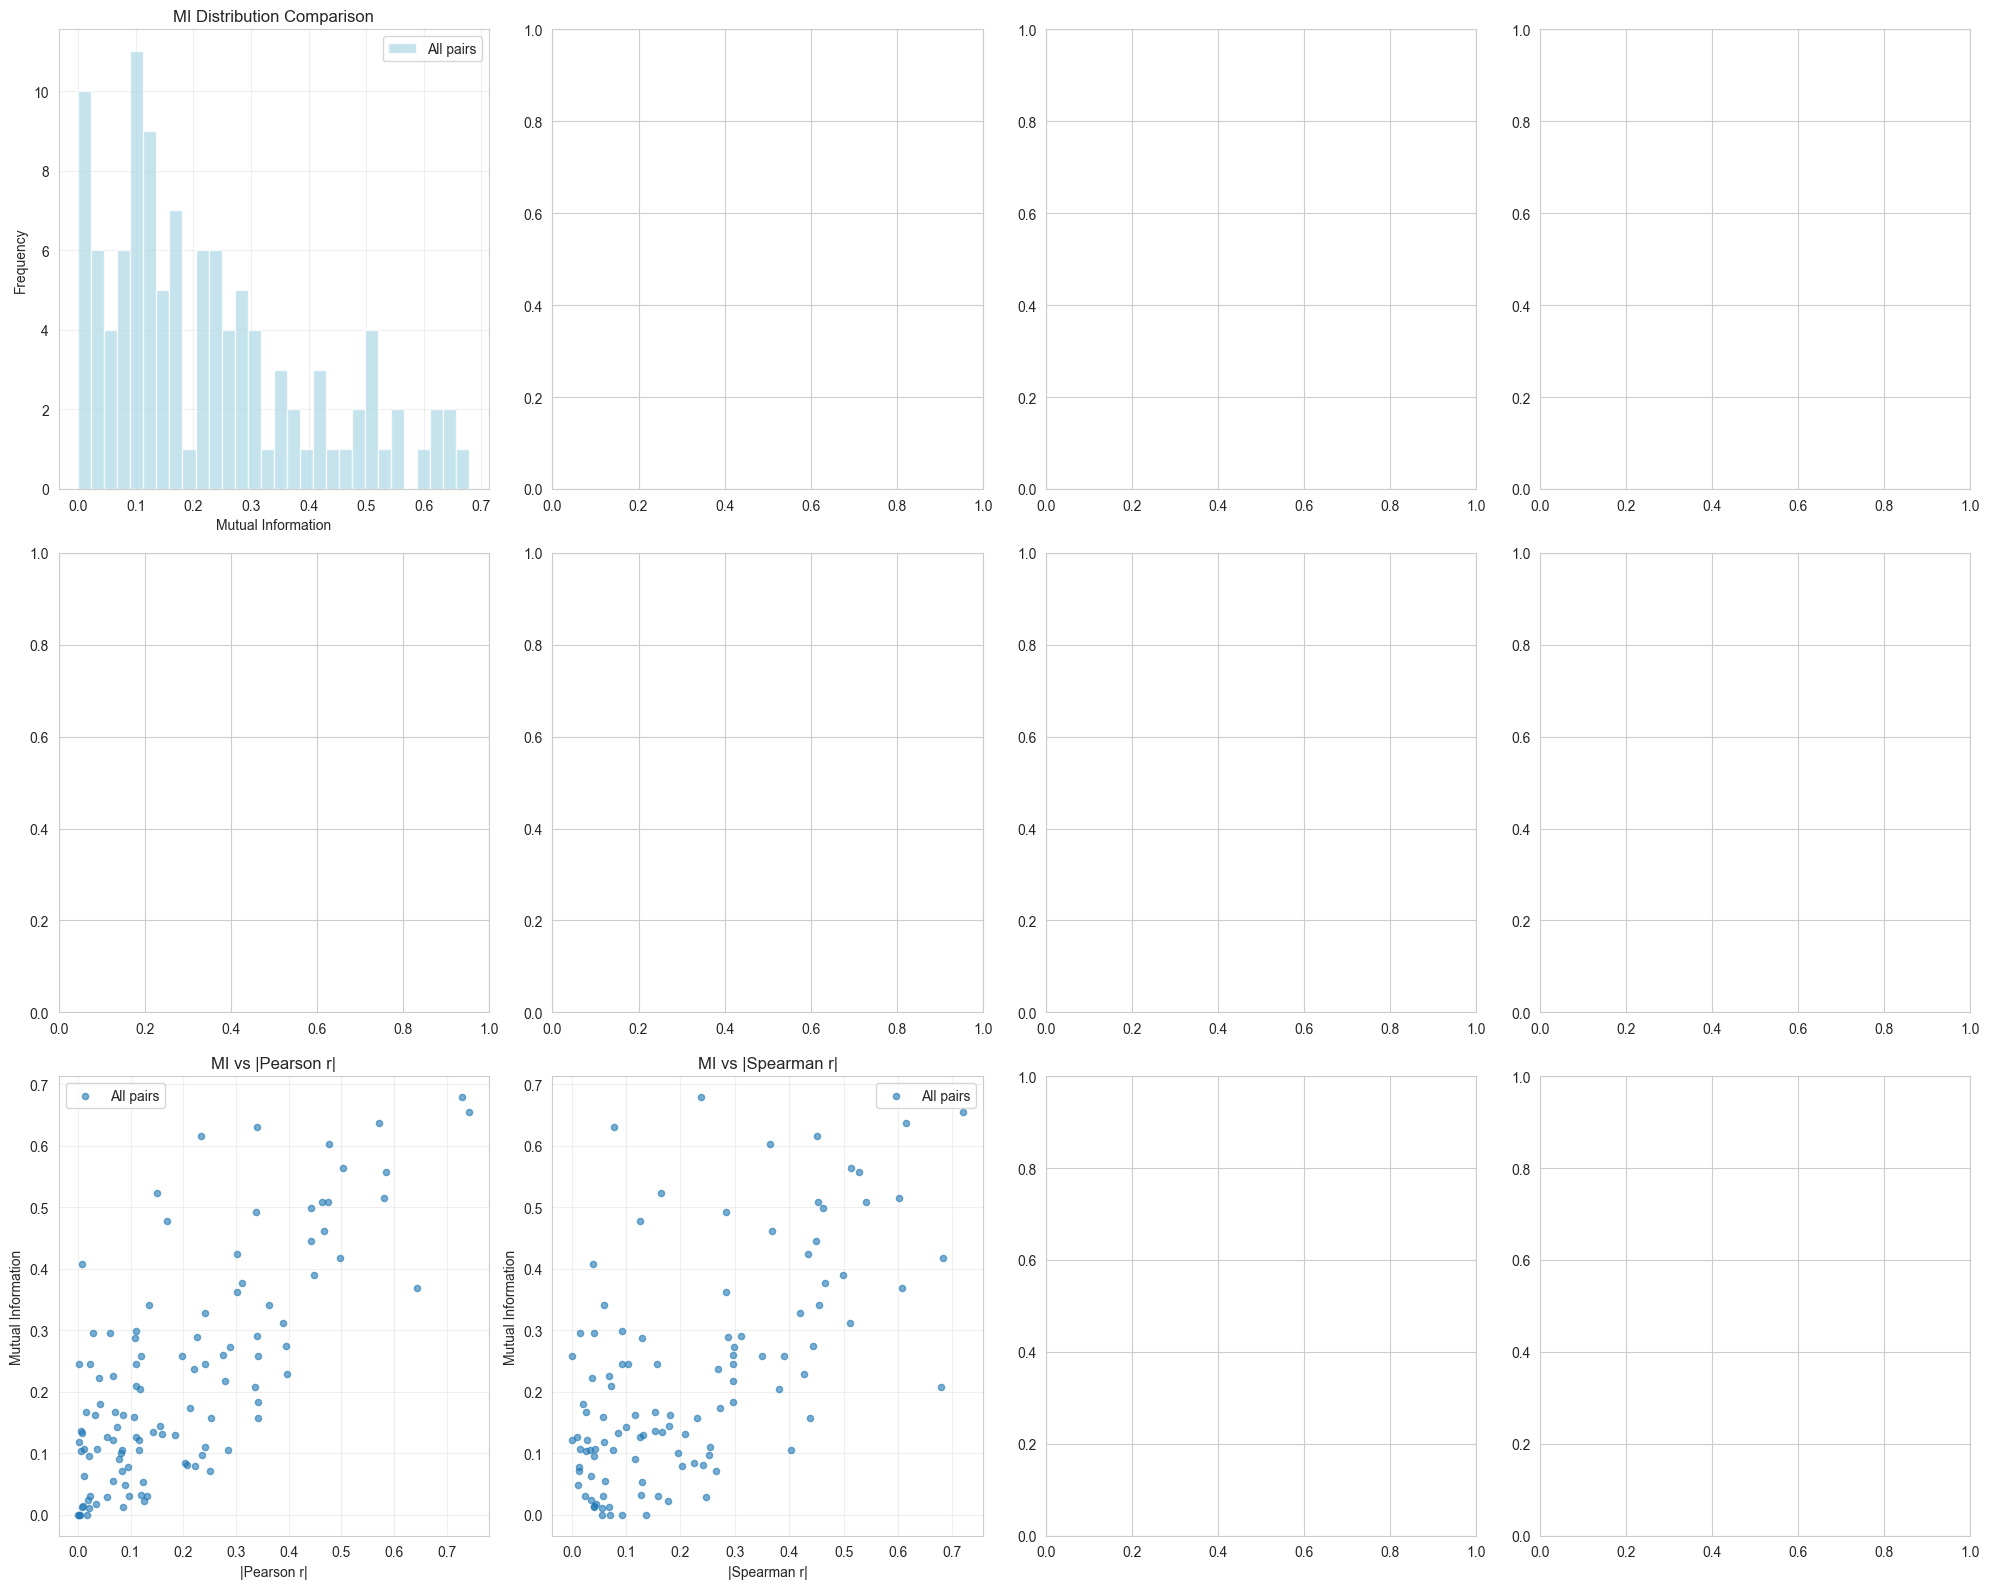

In [27]:
# Create comprehensive visualizations for MI analysis with distance
def create_comprehensive_mi_distance_plots(all_data, distance_data=None, crosstab=None):
    """Create comprehensive plots for MI analysis incorporating distance"""
    
    fig = plt.figure(figsize=(20, 16))
    
    # Plot 1: MI distribution for all data vs data with distance
    ax1 = plt.subplot(3, 4, 1)
    all_data['mi_delta_wte_delta_q'].hist(bins=30, alpha=0.7, label='All pairs', color='lightblue')
    if distance_data is not None:
        distance_data['mi_delta_wte_delta_q'].hist(bins=30, alpha=0.7, label='With distance', color='orange')
    plt.xlabel('Mutual Information')
    plt.ylabel('Frequency')
    plt.title('MI Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Distance distribution
    ax2 = plt.subplot(3, 4, 2)
    if distance_data is not None:
        distance_data['Distance_to_Reach'].hist(bins=50, alpha=0.7, color='green')
        plt.xlabel('Distance to Reach (m)')
        plt.ylabel('Frequency')
        plt.title('Distance Distribution')
        plt.grid(True, alpha=0.3)
    
    # Plot 3: Distance vs MI scatter plot
    ax3 = plt.subplot(3, 4, 3)
    if distance_data is not None:
        plt.scatter(distance_data['Distance_to_Reach'], distance_data['mi_delta_wte_delta_q'], 
                   alpha=0.6, s=20)
        plt.xlabel('Distance to Reach (m)')
        plt.ylabel('Mutual Information')
        plt.title('Distance vs MI')
        plt.grid(True, alpha=0.3)
    
    # Plot 4: Distance vs MI (log scale)
    ax4 = plt.subplot(3, 4, 4)
    if distance_data is not None:
        valid_dist = distance_data[distance_data['Distance_to_Reach'] > 0]
        plt.scatter(valid_dist['Distance_to_Reach'], valid_dist['mi_delta_wte_delta_q'], 
                   alpha=0.6, s=20)
        plt.xscale('log')
        plt.xlabel('Distance to Reach (m, log scale)')
        plt.ylabel('Mutual Information')
        plt.title('Distance vs MI (Log Scale)')
        plt.grid(True, alpha=0.3)
    
    # Plot 5: Box plot by distance category
    ax5 = plt.subplot(3, 4, 5)
    if distance_data is not None and 'distance_category' in distance_data.columns:
        distance_data.boxplot(column='mi_delta_wte_delta_q', by='distance_category', ax=ax5)
        plt.xticks(rotation=45)
        plt.title('MI by Distance Category')
        plt.suptitle('')  # Remove automatic title
    
    # Plot 6: Average MI by distance category
    ax6 = plt.subplot(3, 4, 6)
    if distance_data is not None and 'distance_category' in distance_data.columns:
        avg_mi = distance_data.groupby('distance_category')['mi_delta_wte_delta_q'].mean()
        avg_mi.plot(kind='bar', ax=ax6, color='skyblue')
        plt.xticks(rotation=45)
        plt.ylabel('Average MI')
        plt.title('Average MI by Distance Category')
        plt.grid(True, alpha=0.3)
    
    # Plot 7: Distance vs MI quality heatmap
    ax7 = plt.subplot(3, 4, 7)
    if crosstab is not None:
        sns.heatmap(crosstab, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax7)
        plt.title('Distance vs MI Quality (%)')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
    
    # Plot 8: Count by distance category
    ax8 = plt.subplot(3, 4, 8)
    if distance_data is not None and 'distance_category' in distance_data.columns:
        distance_counts = distance_data['distance_category'].value_counts()
        distance_counts.plot(kind='bar', ax=ax8, color='lightgreen')
        plt.xticks(rotation=45)
        plt.ylabel('Number of Wells')
        plt.title('Well Count by Distance Category')
        plt.grid(True, alpha=0.3)
    
    # Plot 9: MI vs Pearson correlation
    ax9 = plt.subplot(3, 4, 9)
    plt.scatter(all_data['pearson_r'].abs(), all_data['mi_delta_wte_delta_q'], 
               alpha=0.6, s=20, label='All pairs')
    if distance_data is not None:
        plt.scatter(distance_data['pearson_r'].abs(), distance_data['mi_delta_wte_delta_q'], 
                   alpha=0.6, s=20, label='With distance')
    plt.xlabel('|Pearson r|')
    plt.ylabel('Mutual Information')
    plt.title('MI vs |Pearson r|')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 10: MI vs Spearman correlation
    ax10 = plt.subplot(3, 4, 10)
    all_spear = all_data.dropna(subset=['spearman_r'])
    plt.scatter(all_spear['spearman_r'].abs(), all_spear['mi_delta_wte_delta_q'], 
               alpha=0.6, s=20, label='All pairs')
    if distance_data is not None:
        dist_spear = distance_data.dropna(subset=['spearman_r'])
        if len(dist_spear) > 0:
            plt.scatter(dist_spear['spearman_r'].abs(), dist_spear['mi_delta_wte_delta_q'], 
                       alpha=0.6, s=20, label='With distance')
    plt.xlabel('|Spearman r|')
    plt.ylabel('Mutual Information')
    plt.title('MI vs |Spearman r|')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 11: MI quality distribution
    ax11 = plt.subplot(3, 4, 11)
    if distance_data is not None and 'mi_category' in distance_data.columns:
        mi_quality_counts = distance_data['mi_category'].value_counts()
        mi_quality_counts.plot(kind='bar', ax=ax11, color='coral')
        plt.xticks(rotation=45)
        plt.ylabel('Count')
        plt.title('MI Quality Distribution')
        plt.grid(True, alpha=0.3)
    
    # Plot 12: Distance effect on correlation metrics
    ax12 = plt.subplot(3, 4, 12)
    if distance_data is not None and 'distance_category' in distance_data.columns:
        corr_by_dist = distance_data.groupby('distance_category').agg({
            'mi_delta_wte_delta_q': 'mean',
            'pearson_r': lambda x: x.abs().mean(),
            'spearman_r': lambda x: x.abs().mean()
        })
        corr_by_dist.plot(kind='bar', ax=ax12)
        plt.xticks(rotation=45)
        plt.ylabel('Average Value')
        plt.title('Metrics by Distance Category')
        plt.legend(['MI', '|Pearson r|', '|Spearman r|'])
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/mi_distance/comprehensive_mi_distance_analysis.png', 
                dpi=200, bbox_inches='tight')
    plt.show()

# Create comprehensive plots
print("\n=== CREATING COMPREHENSIVE VISUALIZATIONS ===")
create_comprehensive_mi_distance_plots(combined_data, distance_categorized_data, distance_mi_crosstab)

In [28]:
# Save results and create summary report
def save_enhanced_mi_results(all_data, distance_data, stats, crosstab):
    """Save comprehensive MI analysis results"""
    
    print("\n=== SAVING ENHANCED MI ANALYSIS RESULTS ===")
    
    # 1. Save the complete dataset with distance information
    all_data.to_csv('../data/processed/mutual_information_analysis_results.csv', index=False)
    print(f"Saved complete dataset: {len(all_data)} records")
    
    # 2. Save distance-categorized data if available
    if distance_data is not None:
        distance_data.to_csv('../data/processed/mi_with_distance_categories.csv', index=False)
        print(f"Saved distance-categorized data: {len(distance_data)} records")
    
    # 3. Save summary statistics
    stats_df = pd.DataFrame(stats).T
    stats_df.to_csv('../data/processed/mutual_information_by_class_summary.csv')
    print("Saved summary statistics by class")
    
    # 4. Save cross-tabulation if available
    if crosstab is not None:
        crosstab.to_csv('../data/processed/distance_mi_quality_crosstab.csv')
        print("Saved distance vs MI quality cross-tabulation")
    
    # 5. Create a comprehensive summary report
    summary_report = []
    summary_report.append("# Enhanced Mutual Information Analysis with Distance")
    summary_report.append("=" * 50)
    summary_report.append("")
    
    summary_report.append("## Overall Statistics")
    for category, category_stats in stats.items():
        summary_report.append(f"\n### {category}")
        for metric, value in category_stats.items():
            if isinstance(value, float):
                summary_report.append(f"- {metric}: {value:.4f}")
            else:
                summary_report.append(f"- {metric}: {value}")
    
    if distance_data is not None:
        summary_report.append("\n## Distance-Based Analysis")
        summary_report.append(f"- Total pairs with distance data: {len(distance_data)}")
        
        # Distance category summary
        dist_summary = distance_data.groupby('distance_category')['mi_delta_wte_delta_q'].agg(['count', 'mean', 'std']).round(4)
        summary_report.append("\n### MI Statistics by Distance Category:")
        summary_report.append(dist_summary.to_string())
        
        if crosstab is not None:
            summary_report.append("\n### Distance vs MI Quality Cross-tabulation (%):")
            summary_report.append(crosstab.round(1).to_string())
    
    # Save report
    with open('../reports/mutual_information_distance_analysis_report.txt', 'w') as f:
        f.write('\n'.join(summary_report))
    
    print("\nFiles saved:")
    print("- ../data/processed/mutual_information_analysis_results.csv")
    print("- ../data/processed/mi_with_distance_categories.csv")
    print("- ../data/processed/mutual_information_by_class_summary.csv")
    print("- ../data/processed/distance_mi_quality_crosstab.csv")
    print("- ../reports/mutual_information_distance_analysis_report.txt")
    print("- ../reports/figures/mi_distance/comprehensive_mi_distance_analysis.png")
    
    return stats_df

# Save all results
final_summary = save_enhanced_mi_results(
    combined_data, 
    distance_categorized_data, 
    mi_stats, 
    distance_mi_crosstab
)

print("\n=== ANALYSIS COMPLETE ===")
print(f"Total well-gage pairs analyzed: {len(combined_data)}")
if distance_categorized_data is not None:
    print(f"Pairs with distance data: {len(distance_categorized_data)}")
print("Check the saved files for detailed results and visualizations.")


=== SAVING ENHANCED MI ANALYSIS RESULTS ===
Saved complete dataset: 112 records
Saved summary statistics by class

Files saved:
- ../data/processed/mutual_information_analysis_results.csv
- ../data/processed/mi_with_distance_categories.csv
- ../data/processed/mutual_information_by_class_summary.csv
- ../data/processed/distance_mi_quality_crosstab.csv
- ../reports/mutual_information_distance_analysis_report.txt
- ../reports/figures/mi_distance/comprehensive_mi_distance_analysis.png

=== ANALYSIS COMPLETE ===
Total well-gage pairs analyzed: 112
Check the saved files for detailed results and visualizations.
